<a href="https://colab.research.google.com/github/No-Qubit-Left-Behind/NQLB/blob/master/Optimizer_class_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adiabatic Control

In [25]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
print(tf.__version__)


import IPython.display

2.2.0-rc2


In [26]:
class PropagatorVL:
    def __init__(self, input_dim, no_of_steps, delta_t):
        self.delta_t = delta_t
        self.duration = no_of_steps * delta_t
        self.no_of_steps = no_of_steps
        self.initial_state = tf.constant([[1], [0]], dtype = tf.complex128)
        self.target_state = tf.constant([[0], [1]], dtype = tf.complex128)
        self.reg_matrix = tf.constant([[1, 0], [0, 5]], dtype = tf.float64)
        """
            contraction_array determines the neccessity for the extra
            matrix multiplication step in the recursive method self.propagate()
            when the intermediate computation array has length not divisible
            by 2
        """
        self.contraction_array = self.gen_contraction_array(no_of_steps)
        """
            ansatz_basis_matrix performs a transformation to the even/odd
            polynomial basis
        """
        self.ansatz_basis_matrix = self.gen_ansatz_matrix(
            input_dim, no_of_steps, delta_t
        )
        self.I = tf.eye(2, dtype = tf.complex128)
        self.x = tf.constant(
            [[0, 1], [1, 0]], dtype=tf.complex128
        )
        self.y = tf.constant(
            [[0 + 0j, 0 - 1j], [0 + 1j, 0 + 0j]], dtype=tf.complex128
        )
        self.z = tf.constant(
            [[1, 0], [0, -1]], dtype=tf.complex128
        )
        
        """ Van Loan generators for adiabatic control """
        # Hamiltonian
        x_Ham = -2 * np.pi *(0 + 1j) * 0.5 * np.block([
            [self.x.numpy(), np.zeros((2, 2))],
            [np.zeros((2, 2)), self.x.numpy()]          
        ])
        z_Ham = -2 * np.pi *(0 + 1j) * 0.5 * np.block([
            [self.z.numpy(), np.zeros((2, 2))],
            [np.zeros((2, 2)), self.z.numpy()]          
        ])
        # Projector
        I_proj = 0.5 * np.block(
            [[np.zeros((2, 2)), self.I.numpy()],
             [np.zeros((2, 2)), np.zeros((2, 2))]]
        )
        x_proj = 0.5 * np.block(
            [[np.zeros((2, 2)), self.x.numpy()],
             [np.zeros((2, 2)), np.zeros((2, 2))]]
        )
        z_proj = 0.5 * np.block(
            [[np.zeros((2, 2)), self.z.numpy()],
             [np.zeros((2, 2)), np.zeros((2, 2))]]
        )

        self.generators =  tf.stack([
                                     tf.constant(x_Ham, dtype=tf.complex128),
                                     tf.constant(z_Ham, dtype=tf.complex128),
                                     tf.constant(I_proj, dtype=tf.complex128),
                                     tf.constant(x_proj, dtype=tf.complex128),
                                     tf.constant(z_proj, dtype=tf.complex128)
                                     ])

        self.ctrl_amplitudes = tf.Variable(
            tf.zeros([input_dim, 2], dtype=tf.float64), dtype=tf.float64
        )

    @staticmethod
    def gen_contraction_array(no_of_intervals):
        if no_of_intervals > 1:
            return (
                [bool(np.mod(no_of_intervals, 2))] +
                PropagatorVL.gen_contraction_array(
                    np.floor(no_of_intervals / 2)
                )
            )
        return []

    @staticmethod
    def gen_ansatz_matrix(input_dim, output_dim, time_step):
        T = output_dim * time_step
        Rabi_basis = tf.constant(
            [[1 - (1 - 2 * t / T) ** (2 * n)
            for n in range(1, input_dim + 1)]
             for t in np.linspace(0., T, output_dim)],
             dtype = tf.float64
        )
        offset_basis = tf.constant(
            [[(1 - 2 * t / T) ** (2 * n - 1)
            for n in range(1, input_dim + 1)]
             for t in np.linspace(0., T, output_dim)]
            , dtype = tf.float64)
        return [Rabi_basis, offset_basis]

    """
        regularize_amplitudes ensures that no individual amplitude exceeds its
        maximum value
    """
    @staticmethod
    def regularize_amplitudes(amplitudes, reg_matrix):
        tanh_output = tf.math.tanh(amplitudes)
        return tf.linalg.matmul(
            tanh_output, reg_matrix
        )

    """
        return_physical_amplitudes transforms the input array
        self.ctrl_amplitudes into physical control amplitudes
    """    
    def return_physical_amplitudes(self):
        basis = self.ansatz_basis_matrix
        ctrls = self.ctrl_amplitudes
        transformed_Rabi = tf.linalg.matmul(basis[0], ctrls[:, 0:1])
        transformed_offset = tf.linalg.matmul(basis[1], ctrls[:, 1:2])
        transformed_amplitudes = tf.concat(
            [transformed_Rabi, transformed_offset], 1
        )
        regularized_amplitudes = self.regularize_amplitudes(
            transformed_amplitudes, self.reg_matrix
        )
        return regularized_amplitudes
    """
    return_auxiliary_amplitudes outputs all variables needed for the VL 
    generator
    """
    def return_auxiliary_amplitudes(self):
        amplitudes = self.return_physical_amplitudes()
        sgn = tf.math.sign(amplitudes[0, 1])
        normalized_amplitudes = tf.linalg.normalize(
            amplitudes, ord = 'euclidean', axis = 1
        )[0]
        drift_amplitudes = tf.ones((self.no_of_steps, 1), dtype = tf.float64)
        return tf.concat(
            [amplitudes, drift_amplitudes, sgn * normalized_amplitudes], 1
        )


    """
        exponentials() computes a vector matrix exponential after multiplying
        each self.ctrl_amplitudes row with a the vector of matrices in
        self.generators
    """
    def exponentials(self):
        all_amplitudes = self.return_auxiliary_amplitudes()
        exponents = tf.linalg.tensordot(
            tf.cast(all_amplitudes, dtype=tf.complex128),
            self.delta_t * self.generators, 1
        )
        return tf.linalg.expm(exponents)
    
    """
        propagate  computes the final propagator by recursively multiplying
        each odd element in the list of matrices with each even element --
        if the length of the array is not divisible by 2 an extra computation
        step is added
    """
    def propagate(self):
        step_exps = self.exponentials()
        for is_odd in self.contraction_array:
            if is_odd:
                odd_exp = step_exps[-1, :, :]
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0:-1:2, :, :]
                )
                step_exps = tf.concat([
                    step_exps[0:-1, :, :],
                    [tf.linalg.matmul(odd_exp, step_exps[-1, :, :])]
                ], 0)
            else:
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0::2, :, :]
                )
        return tf.squeeze(step_exps)

    """
        metrics computes the final state and adiabaticity metrics
    """
    def metrics(self):
        VL_propagator = self.propagate()
        propagator = VL_propagator[0:2, 0:2]
        ad_integral = VL_propagator[0:2, 2:4]
        final_state = tf.linalg.matmul(
            propagator, self.initial_state
        )
        # Infidelity
        infidelity = 1 - tf.math.abs(
            tf.linalg.matmul(
                self.target_state, final_state, adjoint_a = True
            )[0, 0]
        ) ** 2
        # Adiabaticity metric
        adiabaticity = 1 - (1 / self.duration) * tf.linalg.matmul(
            final_state, 
            tf.linalg.matmul(
                ad_integral, self.initial_state
            ),
            adjoint_a = True
        )[0, 0]
        adiabaticity = tf.cast(adiabaticity, dtype = tf.float64)
        return infidelity, adiabaticity
    """
        target computes the final cost function
    """
    def target(self):
        metrics = self.metrics()
        return 0.2 * metrics[0] + 0.8 * metrics[1]

"""
Inputs to Optimizer class

  ctrl_parameters:  
  optimization variables, a tf.variable object of data type float64.

  optimizer_step: step size for the Adam algorithm.

  final_step: total number of optimization steps per seed.

  steps_to_check:
    A list of integers indicating the optimizer steps at which the target 
    function is compared to the 'thresholds' input.
    Default is [-1] (no checking).

  thresholds:
    A list of target function threshold values. The optimizer reinitializes
    with a new seed if the target function is larger than thresholds[i] on step
    steps_to_check[i], for any i.
    Default is [1].

  min_target_change:
    Minimum change in target function after each step. Optimizer discards the
    seed if the change becomes smaller than this value.
    Default is 0 (no checkin).

  no_of_seeds: Total number of seeds to try.

  goal:
    Goal value for target function. Optimization is stopped if target is smaller
    than this value.

  seed_min, seed_max:
    min and max values for the uniform random distribution used for the seed.
"""
class Optimizer:
  def __init__(self, ctrl_parameters, optimizer_step, final_step,
               steps_to_check = [-1], thresholds = [1], min_target_change = 0,
               no_of_seeds = 1, goal = 0, seed_min = -1, seed_max = 1):
    self.ctrl_parameters = ctrl_parameters
    self.ctrls_shape = tf.shape(ctrl_parameters)
    self.optimizer_step = optimizer_step
    self.final_step = final_step
    self.steps_to_check = steps_to_check
    self.thresholds = thresholds
    self.min_target_change = min_target_change
    self.no_of_seeds = no_of_seeds
    self.goal = goal
    self.seed_min = seed_min
    self.seed_max = seed_max
    self.optimizer = tf.keras.optimizers.Adam(optimizer_step)

  def initialize_seed(self):
    self.ctrl_parameters.assign(
        tf.random.uniform(
            self.ctrls_shape, self.seed_min, self.seed_max, dtype = tf.float64
        )
    )

  @tf.function
  def take_step(self):
    with tf.GradientTape() as tape:
      current_target = propagatorVL.target()
    gradients = tape.gradient(current_target, [self.ctrl_parameters])
    self.optimizer.apply_gradients(zip(gradients, [self.ctrl_parameters]))
    return current_target

  def optimize(self):
    checked_steps = self.steps_to_check
    target_thresholds = self.thresholds
    step_count = self.final_step
    seed_count = self.no_of_seeds
    target_goal = self.goal
    min_target_variation = self.min_target_change
    best_ctrls_so_far = None
    best_target_so_far = 1
    for seed in range(seed_count):
      self.initialize_seed()
      previous_target = 1
      current_target = 1
      for step in range(step_count):
        current_target = self.take_step()
        IPython.display.clear_output(wait=True)
        print(
            'best target so far: %.2E\nseed: %2d\nstep %2d:\ntarget=%.2E\tchange=%.2E'
             % (best_target_so_far, seed + 1, step + 1, current_target,
                previous_target - current_target)
        )
        if current_target <= target_goal:
          print('Goal reached!')
          best_ctrls_so_far = self.ctrl_parameters
          best_target_so_far = current_target
          return
        elif abs(previous_target - current_target) <= min_target_variation:
          print(
              'Seed failed: Change in target is smaller than the given minimum.'
          )
          time.sleep(1)
          break
        elif step in checked_steps:
          step_index = checked_steps.index(step)
          if current_target >= target_thresholds[step_index]:
            print('Seed failed: Target is larger than threshold.')
            time.sleep(1)
            break
        previous_target = current_target
      if current_target < best_target_so_far:
        best_ctrls_so_far = self.ctrl_parameters.numpy()
        best_target_so_far = current_target.numpy()
    IPython.display.clear_output(wait=True)
    print(
        'Optimization finished.\nBest target = ', best_target_so_far,
        '\nBest controls = \n', best_ctrls_so_far
    )


propagatorVL = PropagatorVL(10, 1000, 0.005)
optimization = Optimizer(
    propagatorVL.ctrl_amplitudes, 0.01, 2000, steps_to_check=[-1],
    thresholds= [0], no_of_seeds = 5
)

optimization.optimize()

Optimization finished.
Best target =  0.0009197592658878096 
Best controls = 
 [[ 1.46326081  0.22114127]
 [ 1.06697638  0.10203222]
 [ 2.27861973  0.40919236]
 [ 0.16518647 -0.40988812]
 [-0.15938176 -0.00859242]
 [ 1.19640918  0.2826285 ]
 [ 0.6534339   0.60365161]
 [ 0.0410256   1.14727802]
 [-1.52568231  1.13019171]
 [-0.75206168 -0.32119844]]


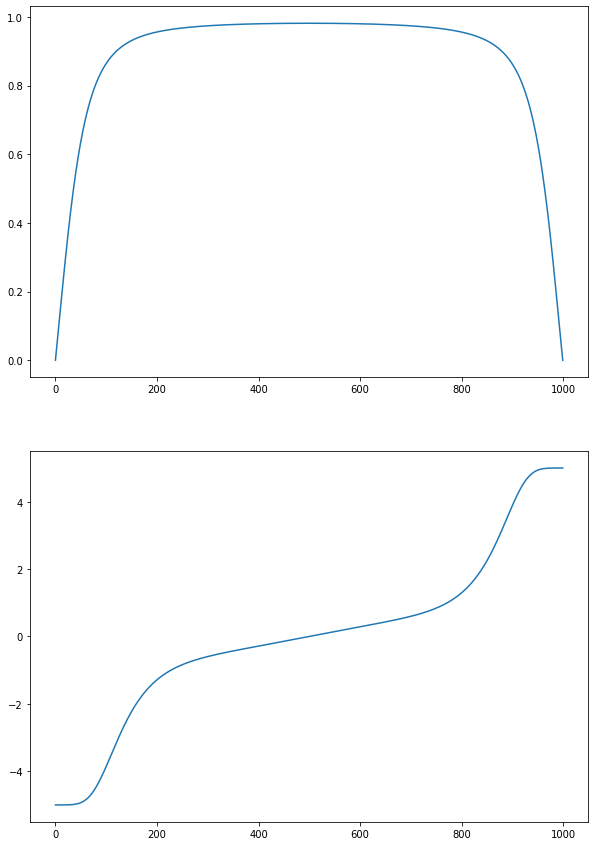

In [27]:
final_pulse = propagatorVL.return_physical_amplitudes().numpy()

fig, (Rabi_fig, offset_fig) = plt.subplots(2, 1, figsize=(10, 15))
Rabi_fig.plot(final_pulse[:,0])
offset_fig.plot(final_pulse[:,1])

In [28]:
# Final state
print(propagatorVL.metrics()[0].numpy())
# Adiabaticity
print(propagatorVL.metrics()[1].numpy())

2.5701634298602727e-05
0.0014470174879007702


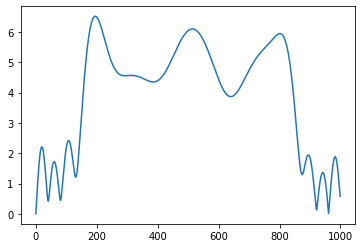

In [29]:
angles = []
exps = propagatorVL.exponentials()
state = propagatorVL.initial_state
for i in range(propagatorVL.no_of_steps):
  state = tf.linalg.matmul(
      exps[i, 0:2, 0:2], state
  )

  sigma_x = tf.linalg.matmul(
      state, tf.linalg.matmul(
          propagatorVL.x, state
      ),
      adjoint_a = True
  )
  sigma_y = tf.linalg.matmul(
      state, tf.linalg.matmul(
          propagatorVL.y, state
      ),
      adjoint_a = True
  )
  sigma_z = tf.linalg.matmul(
      state, tf.linalg.matmul(
          propagatorVL.z, state
      ),
      adjoint_a = True
  )
  sigma = np.ndarray.flatten(
      tf.concat(
          [sigma_x, sigma_y, sigma_z], 0
      ).numpy()
  )

  eff_field = np.array([final_pulse[i, 0], 0, final_pulse[i, 1]])

  angles.append(
      180 - (180 / np.pi) * np.arccos(
          np.dot(eff_field, np.real(sigma))
          / np.linalg.norm(eff_field)
          / np.linalg.norm(sigma)
      )
  )

fig, ax = plt.subplots()
ax.plot(angles)
